In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [3]:
epoch_key = ("Jaq", 3, 16)

In [4]:
from dask.distributed import Client

client = Client(n_workers=32, threads_per_worker=1)
client

/home/edeno/miniconda3/envs/pose_analysis/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42041 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:45851 Dashboard: http://127.0.0.1:42041/status,Cluster Workers: 32 Cores: 32 Memory: 1.62 TB


In [5]:
from src.load_data import load_data

data = load_data(epoch_key, position_to_linearize=['nose_x', 'nose_y'])

13-Oct-20 16:22:59 Loading position info...
13-Oct-20 16:24:01 Task exception was never retrieved
future: <Task finished coro=<connect.<locals>._() done, defined at /home/edeno/miniconda3/envs/pose_analysis/lib/python3.6/site-packages/distributed/comm/core.py:288> exception=CommClosedError()>
Traceback (most recent call last):
  File "/home/edeno/miniconda3/envs/pose_analysis/lib/python3.6/site-packages/distributed/comm/core.py", line 297, in _
    handshake = await asyncio.wait_for(comm.read(), 1)
  File "/home/edeno/miniconda3/envs/pose_analysis/lib/python3.6/asyncio/tasks.py", line 351, in wait_for
    yield from waiter
concurrent.futures._base.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/edeno/miniconda3/envs/pose_analysis/lib/python3.6/site-packages/distributed/comm/core.py", line 304, in _
    raise CommClosedError() from e
distributed.comm.core.CommClosedError
13-Oct-20 16:24:14 Loading mul

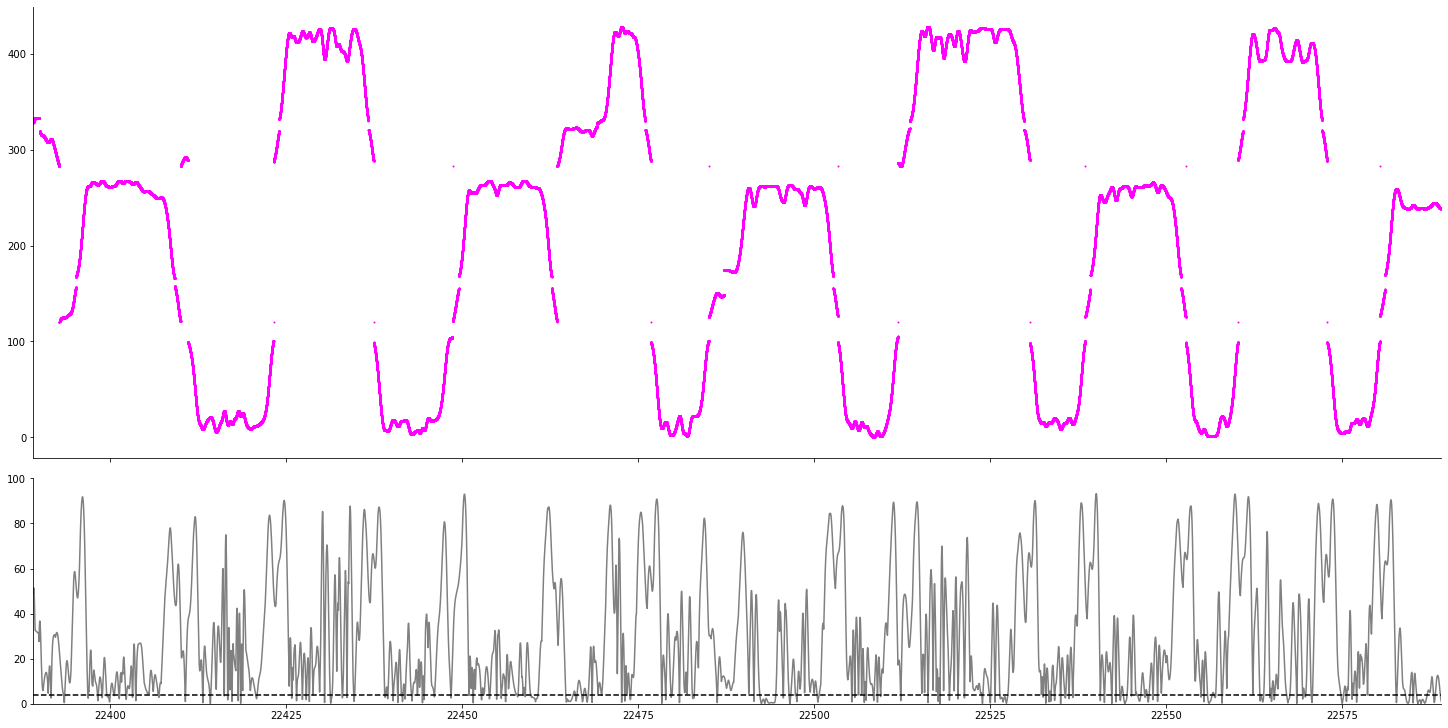

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True, constrained_layout=True, gridspec_kw={'height_ratios': [2, 1]})
time = data['position_info'].index / np.timedelta64(1, 's')
axes[0].scatter(time, data['position_info'].linear_position.values, color='magenta', s=1)
axes[1].plot(time, data['position_info'].nose_vel.values.squeeze(), color='grey')
axes[1].axhline(4, color='black', linestyle='--')
axes[1].set_ylim((0, 100))

plt.xlim((time.min(), time.min() + 200))
sns.despine()

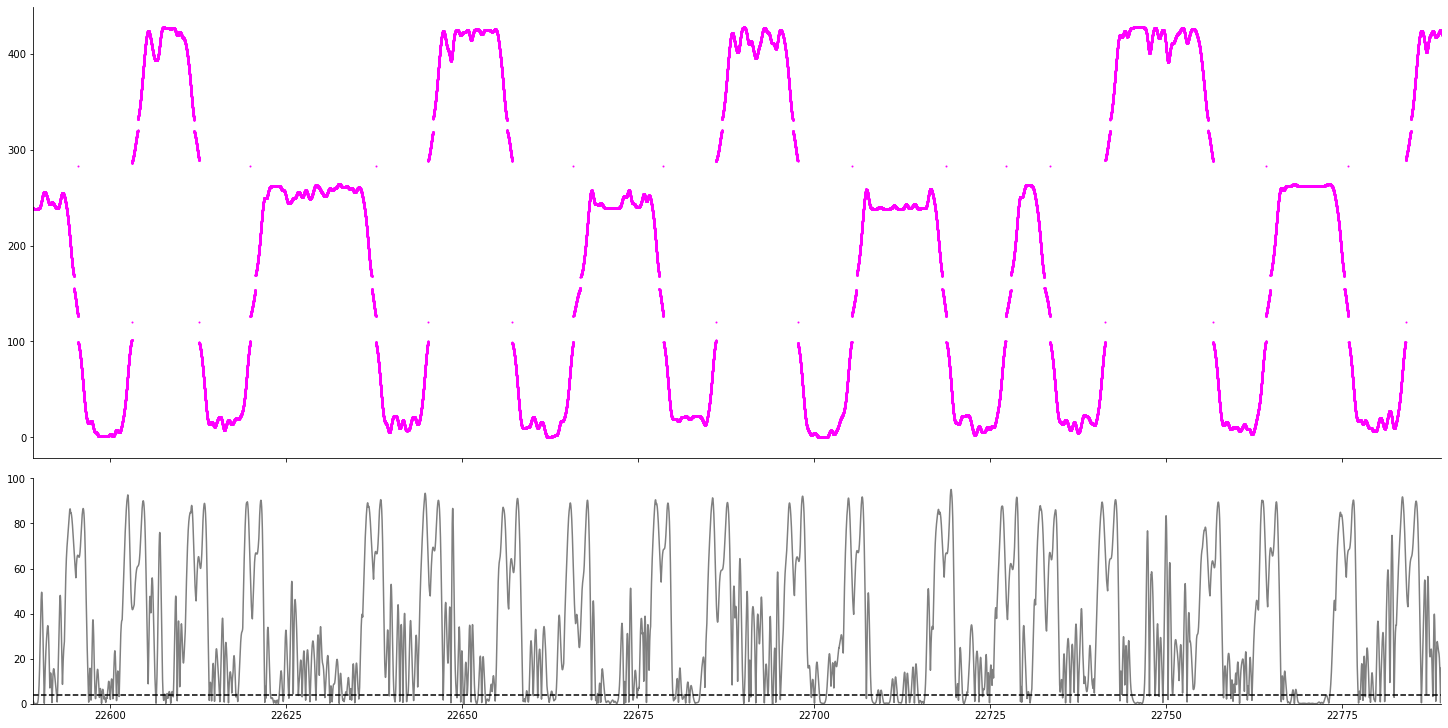

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True, constrained_layout=True, gridspec_kw={'height_ratios': [2, 1]})
time = data['position_info'].index / np.timedelta64(1, 's')
axes[0].scatter(time, data['position_info'].linear_position.values, color='magenta', s=1)
axes[1].plot(time, data['position_info'].nose_vel.values.squeeze(), color='grey')
axes[1].axhline(4, color='black', linestyle='--')
axes[1].set_ylim((0, 100))

plt.xlim((time.min() + 200, time.min() + 400))
sns.despine()

In [9]:
from replay_identification import ReplayDetector

detector_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.0,
    'lfp_model_kwargs': {'n_components': 1, 'max_iter': 200, 'tol': 1e-06},
    'spike_model_knot_spacing': 10,
    'spike_model_penalty': 0.5,
    'movement_state_transition_type': 'random_walk'
}

replay_detector = ReplayDetector(**detector_parameters)
logging.info(replay_detector)

08-Oct-20 21:27:29 ReplayDetector(movement_state_transition_type='random_walk', movement_var=6.0,
               spike_model_knot_spacing=10)


In [ ]:
from src.parameters import EDGE_ORDER, EDGE_SPACING

replay_detector.fit(
    is_ripple=data['is_ripple'],
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    track_graph=data['track_graph'],
    center_well_id=0,
    edge_order=EDGE_ORDER,
    edge_spacing=EDGE_SPACING,
)

08-Oct-20 21:28:58 Fitting speed model...
08-Oct-20 21:29:00 Fitting spiking model...


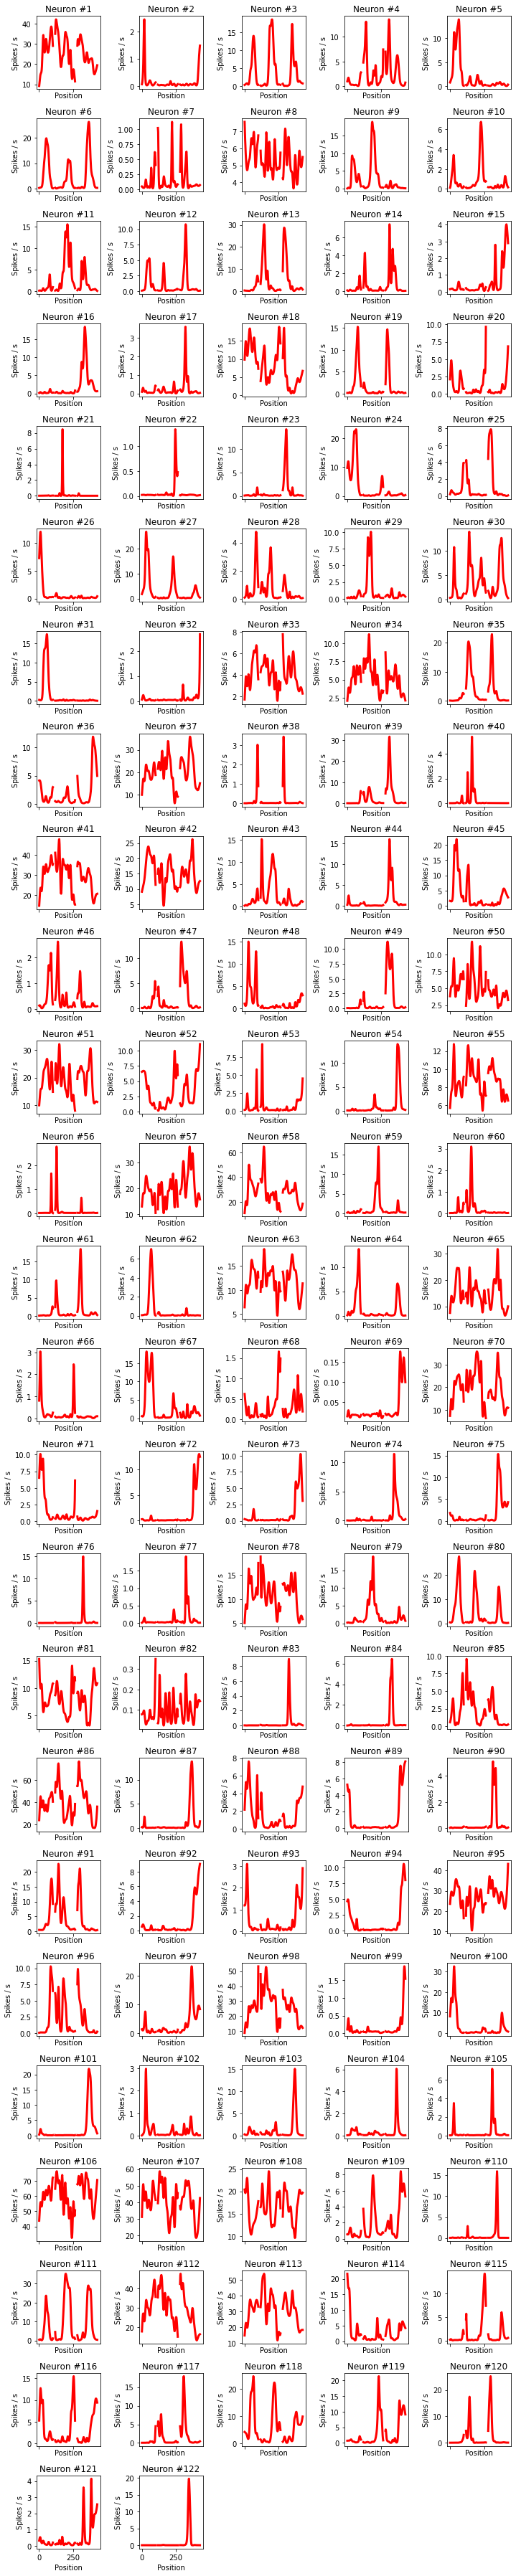

In [13]:
replay_detector.plot_fitted_place_fields(sampling_frequency=500)

In [14]:
import numpy as np

detector_results = replay_detector.predict(
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    time=data['position_info'].index / np.timedelta64(1, 's'),
    use_likelihoods=['spikes'],
    use_smoother=True)

detector_results

09-Oct-20 09:48:33 Predicting spikes likelihood...


09-Oct-20 09:50:30 Finding causal replay probability and position...
09-Oct-20 09:50:49 Finding acausal replay probability and position...


<xarray.Dataset>
Dimensions:             (position: 202, state: 2, time: 454860)
Coordinates:
  * time                (time) float64 1.554e+03 1.554e+03 ... 2.463e+03
  * position            (position) float64 0.9985 2.995 4.992 ... 422.9 424.9
  * state               (state) <U9 'Local' 'Non-Local'
Data variables:
    causal_posterior    (time, state, position) float64 0.0 0.0 ... 1.134e-05
    likelihood          (time, state, position) float64 0.1806 0.1806 ... 1.0
    acausal_posterior   (time, state, position) float64 0.0 0.0 ... 1.134e-05
    replay_probability  (time) float64 0.0 1.014e-72 2.077e-72 ... 0.091 0.09033

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
import copy


def plot_detector(time_ind, data, replay_detector, detector_results,
                  figsize=(11, 6.0)):
    fig, axes = plt.subplots(6, 1,
                             figsize=figsize,
                             sharex=True,
                             constrained_layout=True,
                             gridspec_kw={
                                 'height_ratios': [1, 1, 3, 1, 3, 1]})
    time = data['spikes'].iloc[time_ind].index / np.timedelta64(1, 's')
    
    # axes 0
    max_consensus = data['consensus_ripple_trace'].values.max()
    start_time = data['spikes'].iloc[time_ind].index.min()
    end_time = data['spikes'].iloc[time_ind].index.max()
    consensus_ripple_trace = data['consensus_ripple_trace'].loc[start_time:end_time]
    consensus_ripple_trace_time = consensus_ripple_trace.index / np.timedelta64(1, 's')
    
    axes[0].fill_between(
        time, np.ones_like(time) * max_consensus,
        where=data['ripple_labels'].iloc[time_ind].values.squeeze() > 0,
        color='red', zorder=-2, alpha=0.6, step='pre')
    axes[0].fill_between(
        consensus_ripple_trace_time,
        consensus_ripple_trace.values.squeeze(), color='black')
    axes[0].set_ylim((0, max_consensus))
    axes[0].set_yticks((0, max_consensus))
    axes[0].set_ylabel("Ripple\nPower")
    
    # axes 1
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(
            data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )
    max_multiunit = data["multiunit_firing_rate"].values.max()
    axes[1].fill_between(
        multiunit_firing.iloc[time_ind].index.values,
        multiunit_firing.iloc[time_ind].values.squeeze(),
        color="black",
    )
    axes[1].fill_between(
        time, np.ones_like(time) * max_multiunit,
        where=data["multiunit_high_synchrony_labels"].iloc[time_ind].values.squeeze() > 0,
        color='blue', zorder=-2, alpha=0.6, step='pre')
    axes[1].set_ylim((0, max_multiunit))
    axes[1].set_yticks((0, max_multiunit))
    axes[1].set_ylabel("Multiunit\nRate\n[spikes / s]")

    # axes 2
    place_fields = (
        replay_detector._spiking_likelihood
        .keywords['place_conditional_intensity']).squeeze()
    place_field_max = np.argmax(place_fields, axis=0)
    linear_position_order = place_field_max.argsort(axis=0).squeeze()
    spike_time_ind, neuron_ind = np.nonzero(
        np.asarray(data['spikes'].iloc[time_ind])[:, linear_position_order])

    axes[2].scatter(time[spike_time_ind], neuron_ind,
                    clip_on=False, s=10, color='black', marker='|', rasterized=True)
    axes[2].set_ylim((0, place_fields.shape[1]))
    axes[2].set_yticks((0, place_fields.shape[1]))
    axes[2].set_ylabel('Cells')
    axes[2].fill_between(
        time, np.ones_like(time) * place_fields.shape[1],
        where=detector_results.isel(time=time_ind).replay_probability >= 0.8,
        color='green', zorder=-1, alpha=0.6, step='pre')
    
    # axes 3
    detector_results.isel(time=time_ind).replay_probability.plot(
        x='time', ax=axes[3], color='black', clip_on=False)
    axes[3].set_ylabel('Prob.')
    axes[3].set_xlabel("")
    axes[3].set_ylim((0, 1))

    cmap = copy.copy(plt.get_cmap('bone_r'))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    # axes 4
    (detector_results
     .isel(time=time_ind)
     .acausal_posterior
     .sum('state')
     .where(replay_detector.is_track_interior_)
     .plot(x='time', y='position', ax=axes[4], cmap=cmap,
           vmin=0.0, vmax=0.05))
    axes[4].scatter(data['position_info'].iloc[time_ind].index /
                    np.timedelta64(1, 's'),
                    data['position_info'].iloc[time_ind].linear_position,
                    s=1,
                    color='magenta', clip_on=False)
    axes[4].set_xlabel("")
    max_position = np.ceil(data['position_info'].linear_position.max()).astype(int)
    axes[4].set_yticks((0.0, max_position))
    axes[4].set_ylim((0.0, max_position))
    axes[4].set_ylabel('Position [cm]')
    
    # axes 5
    speed = np.asarray(data['position_info'].iloc[time_ind].nose_vel).squeeze()
    axes[5].fill_between(time, speed, color='grey')
    axes[5].axhline(4, color='black', linestyle='--', linewidth=1)
    axes[5].set_ylabel('Speed\n[cm / s]')
    axes[5].set_yticks((0.0, np.ceil(speed.max()).astype(int)))
    axes[5].set_ylim((0.0, np.ceil(speed.max()).astype(int)))
    
    axes[-1].set_xlabel('Time [s]')
    axes[-1].xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    sns.despine(offset=5)

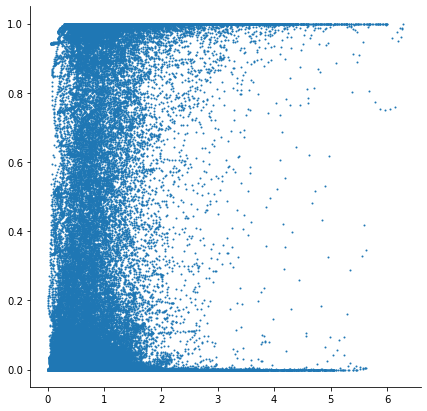

In [228]:
plt.figure(figsize=(7, 7))
plt.scatter(data['multiunit_firing_rate'] / data['multiunit_firing_rate'].mean(), detector_results.replay_probability, s=1)
sns.despine()

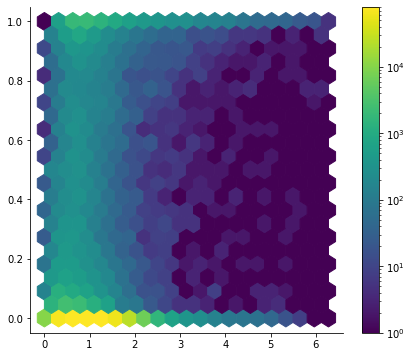

In [227]:
plt.figure(figsize=(7, 6))
plt.hexbin(data['multiunit_firing_rate'].squeeze() / data['multiunit_firing_rate'].values.mean(),
           detector_results.replay_probability.squeeze(),
           gridsize=20, bins='log')
plt.colorbar()
sns.despine()

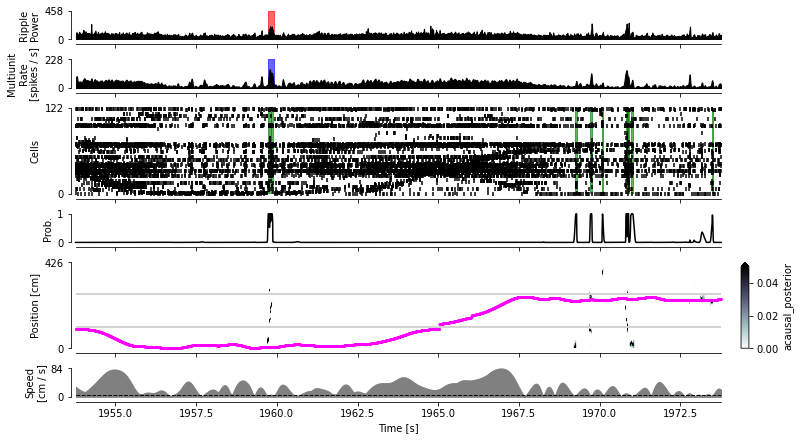

In [158]:
time_ind = slice(200_000, 210_000)

plot_detector(time_ind, data, replay_detector, detector_results)

In [159]:
time_inds = np.stack((np.arange(0, detector_results.time.shape[0], 10_000),
                      np.append(np.arange(10_000, detector_results.time.shape[0], 10_000), detector_results.time.shape[0]-1)
                     ), axis=1)
for ind, (start, end) in enumerate(time_inds):
    time_ind = slice(start, end)
    print(time_ind)
    plot_detector(time_ind, data, replay_detector, detector_results)
    plt.suptitle(f"time: {detector_results.time.values[start]:0.3f} s - {detector_results.time.values[end]:0.3f} s")
    fig_name = f"time_chunks/time_chunk_{ind:02d}"
    plt.savefig(fig_name, bbox_inches='tight')
    plt.close(plt.gcf())

slice(0, 10000, None)
slice(10000, 20000, None)
slice(20000, 30000, None)
slice(30000, 40000, None)
slice(40000, 50000, None)
slice(50000, 60000, None)
slice(60000, 70000, None)
slice(70000, 80000, None)
slice(80000, 90000, None)
slice(90000, 100000, None)
slice(100000, 110000, None)
slice(110000, 120000, None)
slice(120000, 130000, None)
slice(130000, 140000, None)
slice(140000, 150000, None)
slice(150000, 160000, None)
slice(160000, 170000, None)
slice(170000, 180000, None)
slice(180000, 190000, None)
slice(190000, 200000, None)
slice(200000, 210000, None)
slice(210000, 220000, None)
slice(220000, 230000, None)
slice(230000, 240000, None)
slice(240000, 250000, None)
slice(250000, 260000, None)
slice(260000, 270000, None)
slice(270000, 280000, None)
slice(280000, 290000, None)
slice(290000, 300000, None)
slice(300000, 310000, None)
slice(310000, 320000, None)
slice(320000, 330000, None)
slice(330000, 340000, None)
slice(340000, 350000, None)
slice(350000, 360000, None)
slice(360000, 3

In [160]:
from scipy.ndimage.measurements import label
import pandas as pd

def start_time(s):
    return s.index[0]


def end_time(s):
    return s.index[-1]


def max_probability(df):
    return df.max()


def duration(df):
    return (df.index[-1] - df.index[0])


def get_replay_times(results, probability_threshold=0.8,
                     minimum_duration=0.000):

    replay_labels = label(
        results.replay_probability > probability_threshold)[0]
    labels = pd.DataFrame(
        {'replay_number': replay_labels,
         'replay_probability': results.replay_probability.values},
        index=results.time.to_index())

    grouper = labels.loc[labels.replay_number > 0].groupby('replay_number')
    replay_times = (grouper
                    .agg([start_time, end_time, duration, max_probability]))
    replay_times.columns = replay_times.columns.get_level_values(1)

    replay_times = replay_times.loc[replay_times.duration > minimum_duration]
    labels[~labels.isin(replay_times.index.values)] = 0

    return replay_times, labels


In [161]:
replay_info, is_replay = get_replay_times(detector_results)
replay_info

,start_time,end_time,duration,max_probability
replay_number,,,,
1,1556.838588,1557.154588,0.316,0.903411
2,1557.176588,1557.210588,0.034,0.969161
3,1557.294588,1558.156588,0.862,0.999926
4,1560.568588,1561.638588,1.070,0.999980
5,1563.898588,1563.954588,0.056,0.996278
...,...,...,...,...
345,2452.542588,2452.620588,0.078,0.999999
346,2452.638588,2452.658588,0.020,0.993643
347,2452.844588,2452.910588,0.066,0.999089


In [162]:
time_index = np.arange(detector_results.time.size)

for replay_number in replay_info.index:
    start_ind, end_ind = time_index[(is_replay == replay_number).replay_number][[0, -1]]
    start_ind -= 125
    end_ind += 125
    time_ind = slice(start_ind, end_ind)
    print(replay_number)
    figsize = (20 * (end_ind - start_ind) / 1000, 7.5)
    plot_detector(time_ind, data, replay_detector, detector_results, figsize=figsize)
    plt.suptitle(f"Replay Number: {replay_number}")
    fig_name = f"replays/replay_number_{replay_number:03d}"
    plt.savefig(fig_name, bbox_inches='tight')
    plt.close(plt.gcf())

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
220
221
222
223
224
225
226
227
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
280
281
282
283

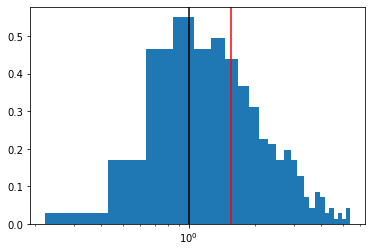

In [238]:
avg_multiunit_rate = []
for replay_number in replay_info.index:
    start_ind, end_ind = time_index[(is_replay == replay_number).replay_number][[0, -1]]
    time_ind = slice(start_ind, end_ind)
    avg_multiunit_rate.append(data['multiunit_firing_rate'].iloc[time_ind].mean())
    
avg_multiunit_rate = np.asarray(avg_multiunit_rate)
plt.hist(avg_multiunit_rate / data['multiunit_firing_rate'].values.mean(), bins=25, density=True);
plt.axvline(1, color='black')
plt.axvline(np.median(avg_multiunit_rate / data['multiunit_firing_rate'].values.mean()), color='red')
plt.xscale('log')

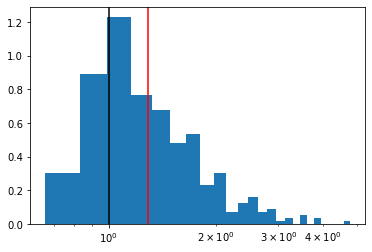

In [239]:
avg_ripple = []
for replay_number in replay_info.itertuples():
    avg_ripple.append(data['consensus_ripple_trace'].set_index(data['consensus_ripple_trace'].index / np.timedelta64(1, 's')).loc[replay_number.start_time:replay_number.end_time].mean())
    
avg_ripple = np.asarray(avg_ripple)
plt.hist(avg_ripple / data['consensus_ripple_trace'].values.mean(), bins=25, density=True);
plt.axvline(1, color='black')
plt.axvline(np.median(avg_ripple / data['consensus_ripple_trace'].values.mean()), color='red')
plt.xscale('log')

In [ ]:
from loren_frank_data_processing import make_actual_vs_linearized_position_movie


make_actual_vs_linearized_position_movie(data['track_graph'], data['position_info'].assign(x_position=data['position_info'].nose_x, y_position=data['position_info'].nose_y))

10-Oct-20 07:24:47 Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
10-Oct-20 07:24:47 MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1512x504 -pix_fmt rgba -r 15 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -metadata artist=Me -y actual_vs_linearized.mp4


In [168]:
(data['position_info']
     .assign(x_position=data['position_info'].nose_x, y_position=data['position_info'].nose_y)
     .iloc[0:data['position_info'].index.shape[0] + 15:15]
    )

,nose_x,nose_y,nose_vel,tailBase_x,tailBase_y,tailBase_vel,tailMid_x,tailMid_y,tailMid_vel,tailTip_x,...,from_well,to_well,task,is_correct,turn,linear_position,linear_velocity,linear_speed,x_position,y_position
time,,,,,,,,,,,,,,,,,,,,,
0 days 00:25:53.764587637,11.902096,25.602505,160.238227,2.245416,31.590870,141.893171,2.211908,27.722790,138.516098,2.476090,...,NaN,NaN,NaN,False,NaN,304.403130,-0.114640,0.114640,11.902096,25.602505
0 days 00:25:53.794587637,13.866159,28.801064,162.429537,2.697739,35.686211,141.709290,2.465775,31.946615,141.528866,3.121661,...,NaN,NaN,NaN,False,NaN,301.169489,-1.718154,1.718154,13.866159,28.801064
0 days 00:25:53.824587637,15.822838,31.715585,161.656768,3.196034,39.410276,138.469331,2.703028,35.959880,141.251280,3.826993,...,NaN,NaN,NaN,False,NaN,298.219973,-3.427643,3.427643,15.822838,31.715585
0 days 00:25:53.854587637,17.871531,34.486475,158.365274,3.776523,42.924658,132.527287,2.940638,39.931137,137.984480,4.625712,...,NaN,NaN,NaN,False,NaN,295.412396,-5.119946,5.119946,17.871531,34.486475
0 days 00:25:53.884587637,19.992423,37.061900,152.869418,4.449560,46.142639,124.272999,3.181797,43.769832,131.894983,5.509269,...,NaN,NaN,NaN,False,NaN,86.240508,-6.786820,6.786820,19.992423,37.061900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:41:03.334587637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,False,NaN,323.753445,27.027394,27.027394,0.000000,0.000000
0 days 00:41:03.364587637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,False,NaN,323.753445,21.688319,21.688319,0.000000,0.000000
0 days 00:41:03.394587637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,False,NaN,323.753445,16.304309,16.304309,0.000000,0.000000


In [ ]:
make_actual_vs_linearized_position_movie(
    data['track_graph'],
    (data['position_info']
     .assign(x_position=data['position_info'].nose_x, y_position=data['position_info'].nose_y)
     .iloc[0:data['position_info'].index.shape[0] + 15:15]
    ))